In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/yolo_det.jpg


In [3]:
!wget -q https://pjreddie.com/media/files/yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


In [4]:
!ls -l


total 242212
-rw-r--r-- 1 root root       625 Apr  5 05:59 coco.names
-rw-r--r-- 1 root root      8342 Apr  5 05:59 yolov3.cfg
-rw-r--r-- 1 root root 248007048 Dec  7  2023 yolov3.weights


In [5]:
import cv2
import numpy as np

# Load YOLOv3 model
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

# Load class labels
def load_classes():
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

# Test the loading function
net, output_layers = load_yolo()
classes = load_classes()
print("YOLO model loaded successfully!")


YOLO model loaded successfully!


In [6]:
import cv2
import numpy as np

# Load YOLOv3 model
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

# Load class labels
def load_classes():
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

# Process image for YOLO detection
def detect_objects(image_path, net, output_layers, classes):
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    
    # Preprocessing image for YOLO
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)
    
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # Apply Non-Maximum Suppression (NMS)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    # Draw bounding boxes and labels
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = (0, 255, 0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    cv2.imwrite("detected_image.jpg", image)
    print("Detection completed, saved as detected_image.jpg")

# Load YOLO model and classes
net, output_layers = load_yolo()
classes = load_classes()

# Provide your image path here
detect_objects("/kaggle/input/images/yolo_det.jpg", net, output_layers, classes)


Detection completed, saved as detected_image.jpg


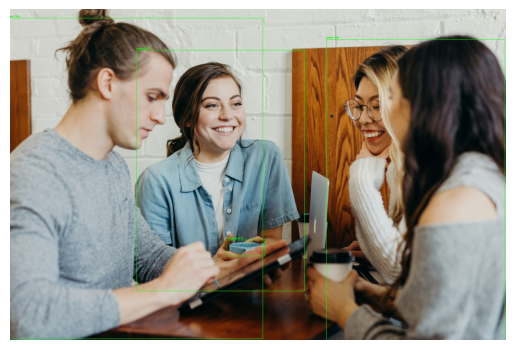

In [7]:
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread("detected_image.jpg")

# Convert from BGR to RGB (Matplotlib uses RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.imshow(img_rgb)
plt.axis("off")  # Hide axis
plt.show()

NMS is used to remove redundant bounding boxes when multiple detections overlap for the same object. 
Without NMS, YOLO may generate multiple overlapping boxes for a single object, making the results cluttered.
NMS helps in selecting the most confident detection while suppressing others, leading to cleaner and more accurate results.

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [12]:
import cv2
import numpy as np

# Load YOLOv3 model
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

# Load class labels
def load_classes():
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

# Process image for YOLO detection with and without NMS
def detect_objects(image_path, net, output_layers, classes, use_nms=True):
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    
    # Preprocessing image for YOLO
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)
    
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    if use_nms:
        # Apply Non-Maximum Suppression (NMS)
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    else:
        indexes = np.arange(len(boxes))  # No suppression, consider all detections
    
    # Draw bounding boxes and labels
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = (0, 255, 0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    output_filename = "detected_image_nms.jpg" if use_nms else "detected_image_no_nms.jpg"
    cv2.imwrite(output_filename, image)
    print(f"Detection completed, saved as {output_filename}")

# Load YOLO model and classes
net, output_layers = load_yolo()
classes = load_classes()

# Provide your image path here
detect_objects("/kaggle/input/images/yolo_det.jpg", net, output_layers, classes, use_nms=True)  # With NMS
detect_objects("/kaggle/input/images/yolo_det.jpg", net, output_layers, classes, use_nms=False)  # Without NMS


Detection completed, saved as detected_image_nms.jpg
Detection completed, saved as detected_image_no_nms.jpg


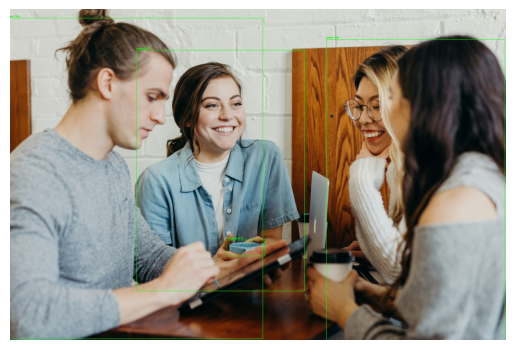

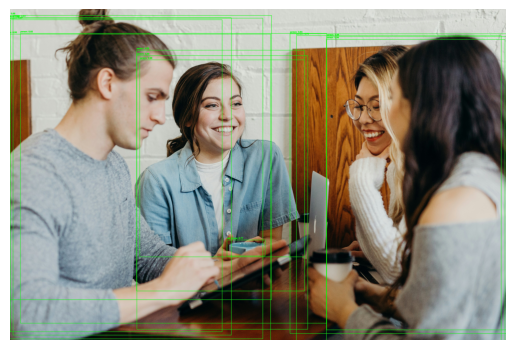

In [13]:
detected_image_nms= cv2.imread("detected_image_nms.jpg")
detected_image_no_nms= cv2.imread("detected_image_no_nms.jpg")
# Convert from BGR to RGB (Matplotlib uses RGB)
detected_image_nms = cv2.cvtColor(detected_image_nms, cv2.COLOR_BGR2RGB)
detected_image_no_nms = cv2.cvtColor(detected_image_no_nms, cv2.COLOR_BGR2RGB)
# Display using matplotlib
plt.imshow(detected_image_nms)
plt.axis("off")  # Hide axis
plt.show()
plt.imshow(detected_image_no_nms)
plt.axis("off")  # Hide axis
plt.show()

In [14]:
!pip install -q ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 46.9 MB/s eta 0:00:00


In [15]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17360, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 17360 (delta 36), reused 18 (delta 18), pack-reused 17308 (from 2)
Receiving objects: 100% (17360/17360), 16.23 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (11898/11898), done.
/kaggle/working/yolov5


In [16]:
import torch
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
from ultralytics import YOLO

# Load the pre-trained YOLOv5 model (COCO dataset)
model = YOLO("yolov5s.pt")  # Use yolov5m.pt, yolov5l.pt for better accuracy

# Run object detection on an image
results = model("/kaggle/input/images/yolo_det.jpg", save=True)
    

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 68.7MB/s]



image 1/1 /kaggle/input/images/yolo_det.jpg: 448x640 3 persons, 1 cup, 1 cell phone, 40.9ms
Speed: 8.1ms preprocess, 40.9ms inference, 223.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


In [18]:
print(os.listdir("/kaggle/working/yolov5/runs/detect/predict/"))

['yolo_det.jpg']


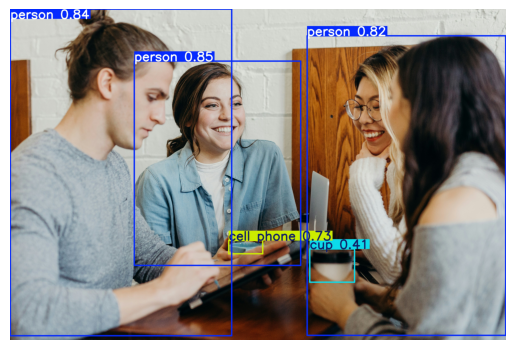

In [19]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/kaggle/working/yolov5/runs/detect/predict/yolo_det.jpg")  # Load detected image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
import cv2
import time
from ultralytics import YOLO

# Load pre-trained YOLOv5 model
model = YOLO("yolov5s.pt")  # You can use "yolov5m.pt" for better accuracy

# Open video file or webcam
video_path = "/kaggle/input/videos/sample.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for saving video
out = cv2.VideoWriter("output.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    start_time = time.time()  # Start time for FPS calculation
    
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    # Run YOLO detection on the frame
    results = model(frame)

    # Get detection results and draw on frame
    for r in results:
        boxes = r.boxes.xyxy  # Bounding box coordinates
        confs = r.boxes.conf   # Confidence scores
        clss = r.boxes.cls     # Class IDs
        
        for box, conf, cls in zip(boxes, confs, clss):
            x1, y1, x2, y2 = map(int, box)  # Convert to integers
            label = f"{model.names[int(cls)]} {conf:.2f}"
            
            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Calculate FPS
    fps = 1.0 / (time.time() - start_time)
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Show the processed frame
    cv2.imshow("YOLOv5 Video", frame)
    out.write(frame)  # Save frame to video

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
print("Processed video saved as output.mp4")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 213MB/s] 


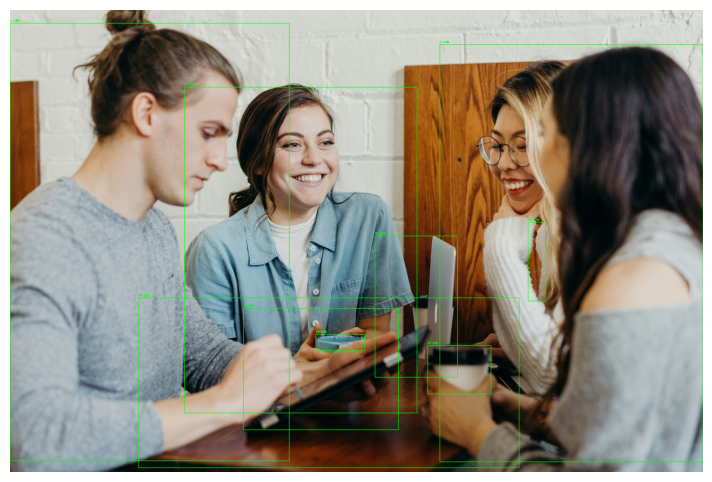

In [20]:
import torch
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Load pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define image transformation
transform = T.Compose([T.ToTensor()])

# Load and preprocess the image
image_path = "/kaggle/input/images/yolo_det.jpg"  # Update with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)  # Convert to tensor and add batch dimension

# Run inference
with torch.no_grad():
    predictions = model(image_tensor)

# Get detected objects, boxes, and confidence scores
boxes = predictions[0]["boxes"]
scores = predictions[0]["scores"]
labels = predictions[0]["labels"]

# Load image using OpenCV for drawing
image_cv = cv2.imread(image_path)

# Draw bounding boxes on detected objects
for box, score, label in zip(boxes, scores, labels):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_cv, f"{label.item()} {score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR to RGB for displaying with Matplotlib
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# Show the image with detected objects
plt.figure(figsize=(10, 6))
plt.imshow(image_cv)
plt.axis("off")
plt.show()


In [21]:
!pip install torch torchvision numpy matplotlib



Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


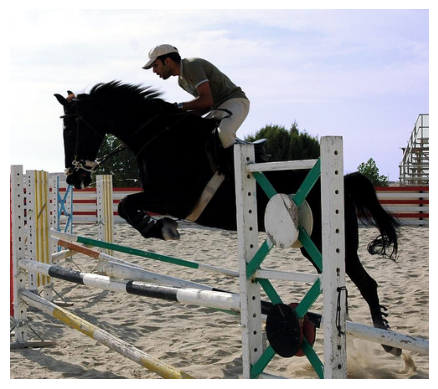

In [23]:
import torch
import torchvision
from torchvision.datasets import VOCDetection
from torchvision import transforms
import matplotlib.pyplot as plt

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Pascal VOC 2012 dataset
dataset = VOCDetection(root="./data", year="2012", image_set="train", download=True, transform=transform)

# Visualize a sample
image, target = dataset[0]
plt.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()


In [24]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for Pascal VOC (21 classes)
num_classes = 21  # Pascal VOC has 20 object classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:

from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


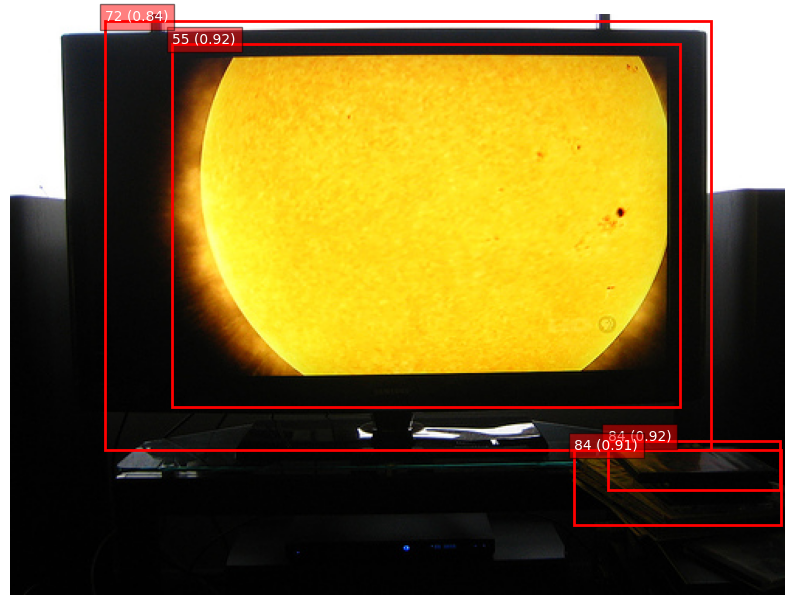

In [27]:
import torch
from torchvision.datasets import VOCDetection
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load sample VOC image
transform = transforms.Compose([transforms.ToTensor()])
dataset = VOCDetection(root="./data", year="2012", image_set="val", download=True, transform=transform)

image, target = dataset[0]
image_tensor = image.unsqueeze(0)  # Add batch dimension

# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
image_tensor = image_tensor.to(device)

# Run inference
with torch.no_grad():
    predictions = model(image_tensor)

# Get results
pred_boxes = predictions[0]['boxes'].cpu()
pred_scores = predictions[0]['scores'].cpu()
pred_labels = predictions[0]['labels'].cpu()

# Plot image with bounding boxes
fig, ax = plt.subplots(1, figsize=(10, 8))
img_np = image.permute(1, 2, 0).numpy()
ax.imshow(img_np)

# Draw boxes with score threshold
threshold = 0.5
for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
    if score > threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label.item()} ({score:.2f})", color="white", bbox=dict(facecolor="red", alpha=0.5))

plt.axis("off")
plt.show()


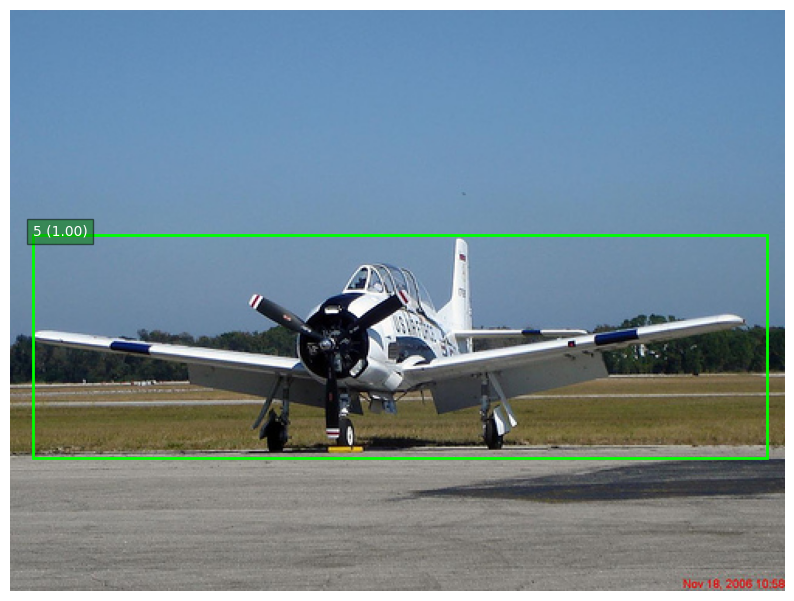

In [29]:
# Get another image from the dataset (e.g., index 5)
image, target = dataset[5]
image_tensor = image.unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    predictions = model(image_tensor)

# Visualize results
pred_boxes = predictions[0]['boxes'].cpu()
pred_scores = predictions[0]['scores'].cpu()
pred_labels = predictions[0]['labels'].cpu()

fig, ax = plt.subplots(1, figsize=(10, 8))
img_np = image.permute(1, 2, 0).numpy()
ax.imshow(img_np)

threshold = 0.5
for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
    if score > threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label.item()} ({score:.2f})", color="white", 
                bbox=dict(facecolor="green", alpha=0.5))

plt.axis("off")
plt.show()
